In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_msssim
from tqdm import tqdm
from PIL import Image

sys.path.append("../")
import utils.data as data
import utils.graphics as graphics
import utils.loss as loss
from models import vqvae

In [2]:
seed = 42
np.random.seed(seed)
_ = torch.manual_seed(seed)

In [3]:
batch_size = 64
num_dataloader_workers = 0

experiment_name = f"vq_vae_v5.10"

num_layers = 0
num_embeddings = 256
embedding_dim = 32
commitment_cost = 0.25
use_max_filters = True
max_filters = 512
image_size = 64
use_noise_images = True
small_conv = True  # To use the 1x1 convolution layer
encoding_dim = image_size // (2 ** num_layers)

data_folder = "..\\data\\Pokemon\\original_data"

output_dir = f"..\\outputs\\{experiment_name}"
model_path = os.path.join(output_dir, "model.pt")

In [4]:
# Setup Device
gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")
print(gpu, device)

False cpu


# Load Model

In [5]:
model = vqvae.VQVAE(
    num_layers=num_layers,
    input_image_dimensions=image_size,
    small_conv=small_conv,
    embedding_dim=embedding_dim,
    num_embeddings=num_embeddings,
    commitment_cost=commitment_cost,
    use_max_filters=use_max_filters,
    max_filters=max_filters,
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(256, 32)
  )
  (decoder): Sequential(
    (0): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ConvTranspose2d(512, 3, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Sigmoid()
  )
)

# Load Data

In [10]:
def load_data(data_folder, image_size, transform):
    pokemon = {}
    background = Image.new("RGBA", (image_size, image_size), (255, 255, 255))
    for file in os.listdir(data_folder):
        id_ = file.split('.')[0].split('_')[0].split('-')[0]
        form = '_'.join(file.split('.')[0].split('_')[1:])
        image = Image.open(os.path.join(data_folder, file))
        image = image.resize((image_size, image_size), resample=Image.BICUBIC).convert("RGBA")
        image = Image.alpha_composite(background, image).convert("RGB")
        if id_ not in pokemon:
            pokemon[id_] = {}
        pokemon[id_][form] = transform(image)
    return pokemon

In [11]:
def image_from_array(image, model_output=False):
    if model_output:
        image = image.detach().squeeze(0)
    plt.imshow(image.permute(1, 2, 0).numpy())

In [12]:
transform = data.image2tensor_resize(image_size)
dataset = load_data(data_folder, image_size, transform)

# Color Rotation

In [13]:
def modify_encodings(encodings, background, maximum, offset):
    encodings[encodings != background] = encodings[encodings != background] + offset
    encodings[encodings >= maximum] = encodings[encodings >= maximum] - maximum
    return encodings

In [46]:
background_encoding = 112
target_shape = (1, encoding_dim, encoding_dim, embedding_dim)

In [85]:
x = dataset['003']['base_bw']
constant = dataset['003']['base_shiny_bw']

In [86]:
encodings = model(x.unsqueeze(0))[3]
constant_encodings = model(constant.unsqueeze(0))[3]

In [87]:
encodings = model(x.unsqueeze(0))[3]
x_hat = model.quantize_and_decode(encodings, target_shape, device)

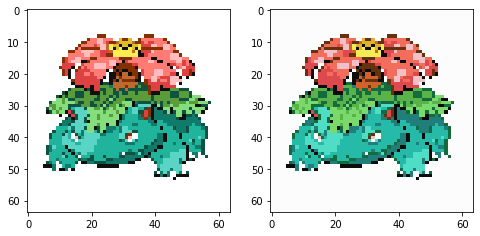

In [88]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
image_from_array(x)
fig.add_subplot(1, 2, 2)
image_from_array(x_hat, model_output=True)

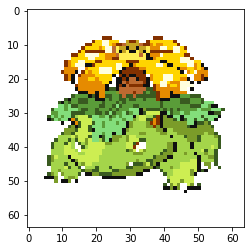

In [89]:
image_from_array(constant)

In [102]:
encodings_hat = modify_encodings(encodings, constant_encodings, num_embeddings, 24)
x_hat = model.quantize_and_decode(encodings_hat, target_shape, device)

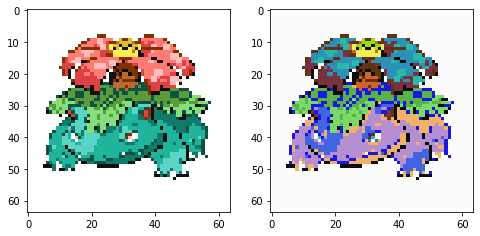

In [103]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
image_from_array(x)
fig.add_subplot(1, 2, 2)
image_from_array(x_hat, model_output=True)

In [47]:
all_generated = []
for i in range(256):
    encodings_hat = modify_encodings(encodings, constant_encodings, num_embeddings, i)
    x_hat = model.quantize_and_decode(encodings_hat, target_shape, device)
    x_hat = x_hat.detach().squeeze(0).permute(1, 2, 0).numpy()
    x_hat = Image.fromarray((x_hat * 255).astype(np.uint8))
    all_generated.append(x_hat)

KeyboardInterrupt: 

In [ ]:
all_generated[0].save(
    fp="charizard.gif", format='GIF', append_images=all_generated[1:], save_all=True, duration=300, loop=0, optimize=False
)

# Palette Swap

In [104]:
def get_color_palette(encodings):
    colors, counts = encodings.unique(return_counts=True)
    return [int(x) for _, x in sorted(zip(counts, colors))][::-1]

In [105]:
def swap_palette(encoding, palette, new_palette):
    for old, new in zip(palette, new_palette):
        encoding[encoding == old] = new
    return encoding.unsqueeze(1)

In [106]:
def get_swapped_images(encodings):
    x1_encoding, x2_encoding = encodings.view(2, -1)
    x1_palette = get_color_palette(x1_encoding)
    x2_palette = get_color_palette(x2_encoding)
    x1_swapped = swap_palette(x1_encoding, x1_palette, x2_palette)
    x2_swapped = swap_palette(x2_encoding, x2_palette, x1_palette)
    return torch.cat([x1_swapped, x2_swapped])

In [107]:
background_encoding = 112
target_shape = (2, encoding_dim, encoding_dim, embedding_dim)

In [130]:
x1 = dataset['025']['base_bw']
x2 = dataset['001']['base_bw']

In [131]:
encodings = model(torch.stack([x1, x2]))[3]
x_in = model.quantize_and_decode(encodings, target_shape, device)

In [132]:
encodings_hat = get_swapped_images(encodings)
x_hat = model.quantize_and_decode(encodings_hat, target_shape, device)

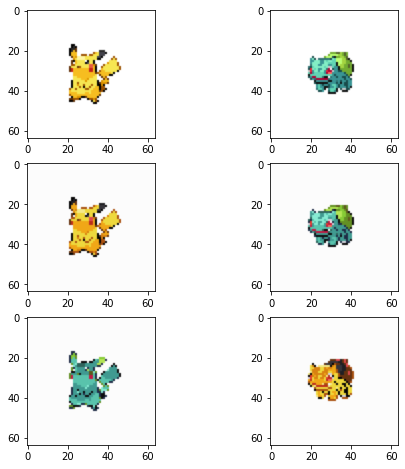

In [133]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(3, 2, 1)
image_from_array(x1)
fig.add_subplot(3, 2, 2)
image_from_array(x2)
fig.add_subplot(3, 2, 3)
image_from_array(x_in[0], True)
fig.add_subplot(3, 2, 4)
image_from_array(x_in[1], True)
fig.add_subplot(3, 2, 5)
image_from_array(x_hat[0], True)
fig.add_subplot(3, 2, 6)
image_from_array(x_hat[1], True)